In [4]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks

rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

# Get ZTF fit

In [5]:
# Local Configuration
data_fink = "../"
bft_file = os.path.join(data_fink, "data", "ssoBFT-latest.parquet")

In [6]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [7]:
# ZTF filters 1: g, 2: r
filters = {"1": "g", "2": "r"}

S_color = {"g": -0.3928, "r": 0.2913}
sun_color = {"g": -0.3044, "r": 0.1903}

color_C = -(sun_color["g"] - sun_color["r"])
color_S = -(S_color["g"] - S_color["r"])

fink_colors = ["#15284F", "#F5622E"]

V_minus_g = -0.2833
V_minus_r = 0.1777

In [8]:
data = pd.read_parquet(os.path.join(data_fink, "data", "ztf", "sso_ZTF.parquet"))

In [9]:
data.columns

Index(['ssnamenr', 'HG_chi2red', 'HG_status', 'HG_fit', 'HG_rms', 'HG_rms_g',
       'HG_rms_r', 'HG_median_error_phot', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       'HG_H_r', 'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_flag', 'HG1G2_chi2red',
       'HG1G2_status', 'HG1G2_fit', 'HG1G2_rms', 'HG1G2_rms_g', 'HG1G2_rms_r',
       'HG1G2_median_error_phot', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g',
       'HG1G2_dG1_g', 'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_H_r', 'HG1G2_dH_r',
       'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_flag',
       'SHG1G2_chi2red', 'SHG1G2_min_cos_lambda', 'SHG1G2_mean_cos_lambda',
       'SHG1G2_max_cos_lambda', 'SHG1G2_status', 'SHG1G2_fit', 'SHG1G2_rms',
       'SHG1G2_rms_g', 'SHG1G2_rms_r', 'SHG1G2_median_error_phot',
       'SHG1G2_median_error_phot_1', 'SHG1G2_median_error_phot_2', 'n_obs',
       'n_obs_g', 'n_obs_r', 

In [10]:
data["SHG1G2_dSpin"] = np.sqrt(
    (data["SHG1G2_dalpha0"] * np.cos(np.radians(data["SHG1G2_delta0"]))) ** 2
    + data["SHG1G2_ddelta0"] ** 2
)


# # Remove solutions above 90 deg of latitude
cond = data.SHG1G2_delta0 > 90
data.loc[cond, "SHG1G2_delta0"] = 90
print(f"above 90: {len(data[cond])} ")

cond = data.SHG1G2_delta0 < -90
data.loc[cond, "SHG1G2_delta0"] = -90
print(f"below 90: {len(data[cond])} ")

above 90: 0 
below 90: 0 


In [11]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "orbital_elements.semi_major_axis.value",
    "orbital_elements.eccentricity.value",
    "orbital_elements.inclination.value",
    "orbital_elements.node_longitude.value",
    "orbital_elements.perihelion_argument.value",
    "orbital_elements.mean_anomaly.value",
    "orbital_elements.mean_motion.value",
    "family.family_number",
    "family.family_name",
    "proper_elements.proper_semi_major_axis.value",
    "proper_elements.proper_eccentricity.value",
    "proper_elements.proper_inclination.value",
    "proper_elements.proper_sine_inclination.value",
    "tisserand_parameters.Jupiter.value",
    "albedo.value",
    "absolute_magnitude.value",
    "diameter.value",
    "taxonomy.class",
    "taxonomy.complex",
    "taxonomy.waverange",
    "taxonomy.scheme",
    "taxonomy.technique",
    "colors.g-r.color.value",
    "colors.g-r.color.error.min",
    "colors.g-r.color.error.max",
    "colors.g-r.facility",
    "colors.g-r.observer",
    "colors.g-r.epoch",
    "colors.g-r.delta_time",
    "colors.g-r.id_filter_1",
    "colors.g-r.id_filter_2",
    "colors.g-r.phot_sys",
    "colors.g-r.technique",
    "spins.1.obliquity",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.RA0.error.max",
    "spins.1.DEC0.error.max",
    "spins.1.long.value",
    "spins.1.lat.value",
    "spins.1.technique",
    "spins.2.obliquity",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.RA0.error.max",
    "spins.2.DEC0.error.max",
    "spins.2.long.value",
    "spins.2.lat.value",
    "spins.2.technique",
    "spins.3.obliquity",
    "spins.3.RA0.value",
    "spins.3.DEC0.value",
    "spins.3.RA0.error.max",
    "spins.3.DEC0.error.max",
    "spins.3.long.value",
    "spins.3.lat.value",
    "spins.3.technique",
    "spins.4.obliquity",
    "spins.4.RA0.value",
    "spins.4.DEC0.value",
    "spins.4.RA0.error.max",
    "spins.4.DEC0.error.max",
    "spins.4.long.value",
    "spins.4.lat.value",
    "spins.4.technique",
]
bft = pd.read_parquet(bft_file, columns=cols)

In [12]:
data = data.merge(bft, left_on="name", right_on="sso_name", how="left")

In [13]:
# data

In [14]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit == 0) & (data.HG_status >= 2)
mask_HG = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (
    (data.HG1G2_G1_g > thres)
    & (data.HG1G2_G2_g > thres)
    & ((1 - data.HG1G2_G1_g - data.HG1G2_G2_g) > thres)
)
mask_HG1G2_r = (
    (data.HG1G2_G1_r > thres)
    & (data.HG1G2_G2_r > thres)
    & ((1 - data.HG1G2_G1_r - data.HG1G2_G2_r) > thres)
)
mask_HG1G2_fit = (data.HG1G2_fit == 0) & (data.HG1G2_status >= 2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_SHG1G2_g = (
    (data.SHG1G2_G1_g > thres)
    & (data.SHG1G2_G2_g > thres)
    & ((1 - data.SHG1G2_G1_g - data.SHG1G2_G2_g) > thres)
)
mask_SHG1G2_r = (
    (data.SHG1G2_G1_r > thres)
    & (data.SHG1G2_G2_r > thres)
    & ((1 - data.SHG1G2_G1_r - data.SHG1G2_G2_r) > thres)
)
mask_SHG1G2_ZTF = mask_SHG1G2_g & mask_SHG1G2_r
mask_SHG1G2_fit = (data.SHG1G2_fit == 0) & (data.SHG1G2_status >= 2)
mask_SHG1G2 = mask_SHG1G2_fit & mask_SHG1G2_ZTF


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (
    (data.SHG1G2_alpha0 > thres)
    & (np.abs(360 - data.SHG1G2_alpha0) > thres)
    & (np.abs(data.SHG1G2_alpha0 - 180) > thres)
    & (np.abs(data.SHG1G2_delta0) > thres)
)

# Phase coverage
maskPhase = data.min_phase < 2.5

# Global mask
mask = mask_HG1G2 & mask_SHG1G2

# Global mask
maskFINK = mask_SHG1G2 & maskSpin  # & maskPhase


print(f" All data       : {len(data):6d}  ({100:>6.2f}%)")
print()
print(
    f"  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask SHG1G2 g  : {len(data[mask_SHG1G2_g]):6d}  ({100.*len(data[mask_SHG1G2_g])/len(data):>6.2f}%)"
)
print(
    f"  Mask SHG1G2 r  : {len(data[mask_SHG1G2_r]):6d}  ({100.*len(data[mask_SHG1G2_r])/len(data):>6.2f}%)"
)
print(
    f"  Mask SHG1G2 g+r: {len(data[mask_SHG1G2]):6d}  ({100.*len(data[mask_SHG1G2])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)"
)
print()
print(
    f"  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)"
)
for min_phase in [2, 3, 4, 5]:
    maskPhase = data.min_phase < min_phase
    print(
        f"  Mask phase {min_phase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)"
    )


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_SHG1G2_g]), len(data[mask_SHG1G2_r]), len(data[mask_SHG1G2])

 All data       : 122675  (100.00%)

  Mask HG g      : 122371  ( 99.75%)
  Mask HG r      : 122373  ( 99.75%)
  Mask HG g+r    : 120010  ( 97.83%)

  Mask HG1G2 g   :  63922  ( 52.11%)
  Mask HG1G2 r   :  68956  ( 56.21%)
  Mask HG1G2 g+r :  47175  ( 38.46%)

  Mask SHG1G2 g  :  79912  ( 65.14%)
  Mask SHG1G2 r  :  84779  ( 69.11%)
  Mask SHG1G2 g+r:  64209  ( 52.34%)

  Mask Spin      : 118811  ( 96.85%)

  Mask (both)    :  40935  ( 33.37%)
  Mask phase 2  :  62923  ( 51.29%)
  Mask phase 3  :  86161  ( 70.24%)
  Mask phase 4  : 100699  ( 82.09%)
  Mask phase 5  : 109011  ( 88.86%)


# Abs mag

<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_326420/166354257.py:40: SyntaxWarning: invalid escape sequence '\D'
  a.set_xlabel('$\Delta H = H_{lit} - H_s$')


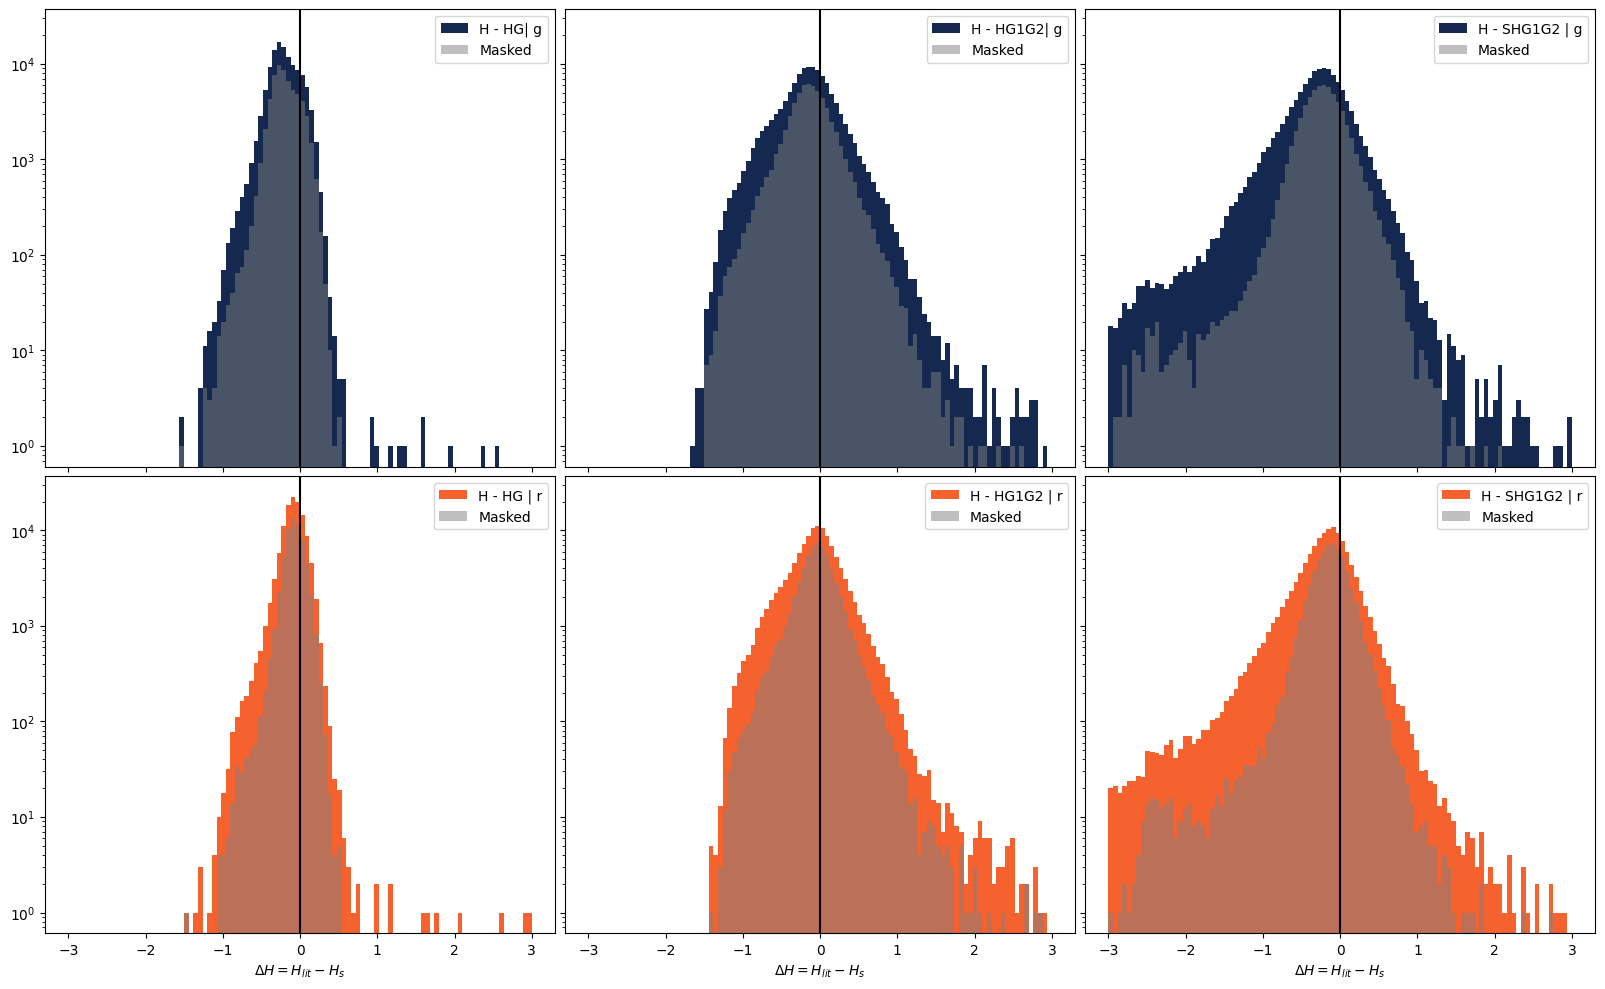

In [15]:
# Different colors
fig, ax = plt.subplots(
    2,
    3,
    figsize=(20, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.02, "wspace": 0.02},
)

r = [-3, 3]
b = 100


# HG
x = (data["absolute_magnitude.value"] - data.HG_H_g) - V_minus_g
ax[0, 0].hist(x, range=r, bins=b, label="H - HG| g", color=fink_colors[0])
ax[0, 0].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.HG_H_r) - V_minus_r
ax[1, 0].hist(x, range=r, bins=b, label="H - HG | r", color=fink_colors[1])
ax[1, 0].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


# HG1G2
x = (data["absolute_magnitude.value"] - data.HG1G2_H_g) - V_minus_g
ax[0, 1].hist(x, range=r, bins=b, label="H - HG1G2| g", color=fink_colors[0])
ax[0, 1].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.HG1G2_H_r) - V_minus_r
ax[1, 1].hist(x, range=r, bins=b, label="H - HG1G2 | r", color=fink_colors[1])
ax[1, 1].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


# SHG1G2
x = (data["absolute_magnitude.value"] - data.SHG1G2_H_g) - V_minus_g
ax[0, 2].hist(x, range=r, bins=b, label="H - SHG1G2 | g", color=fink_colors[0])
ax[0, 2].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.SHG1G2_H_r) - V_minus_r
ax[1, 2].hist(x, range=r, bins=b, label="H - SHG1G2 | r", color=fink_colors[1])
ax[1, 2].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


for a in ax.ravel():
    a.set_xlabel("$\Delta H = H_{lit} - H_s$")
    a.legend(loc="upper right")
    a.set_yscale("log")
    a.axvline(0, color="black")

fig.savefig(os.path.join(data_fink, "gfx", "models", "H.png"), facecolor="white")

Fink 14.78
DAMIT 13.65
6.389683567961346 3.7973388404742066


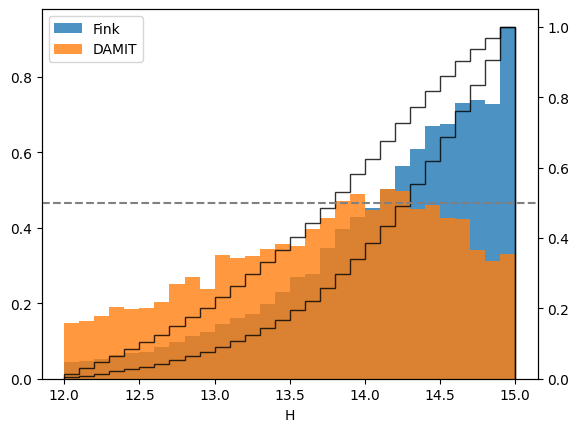

In [47]:
fig, ax = plt.subplots()

r_H = [5, 20]
b_H = 30
r_H = [12, 15]

damit_file = os.path.join(data_fink, "data", "damit_abc.csv")
damit = pd.read_csv(damit_file)
damit = damit.merge(bft, left_on="number", right_on="sso_number", how="left")

ax2 = ax.twinx()

for x, l in zip(
    [data.loc[maskFINK, "absolute_magnitude.value"], damit["absolute_magnitude.value"]],
    ["Fink", "DAMIT"],
):
    ax.hist(x, range=r_H, bins=b_H, density=True, alpha=0.8, label=l)

    ax2.hist(
        x,
        range=r_H,
        bins=b_H,
        density=True,
        cumulative=True,
        histtype="step",
        alpha=0.8,
        label=l,
        color="black",
    )

    print(l, np.nanmedian(x))

ax2.axhline(0.5, color="grey", linestyle="dashed")

# delta Hmag = 0.5
p_damit = 13.65
p_fink = 14.78
pv = 0.15
print( (1329/np.sqrt(pv))*10**(-0.2*p_damit), (1329/np.sqrt(pv))*10**(-0.2*p_fink) )


ax.set_xlabel("H")
ax.legend(loc="upper left")

# Spin distribution

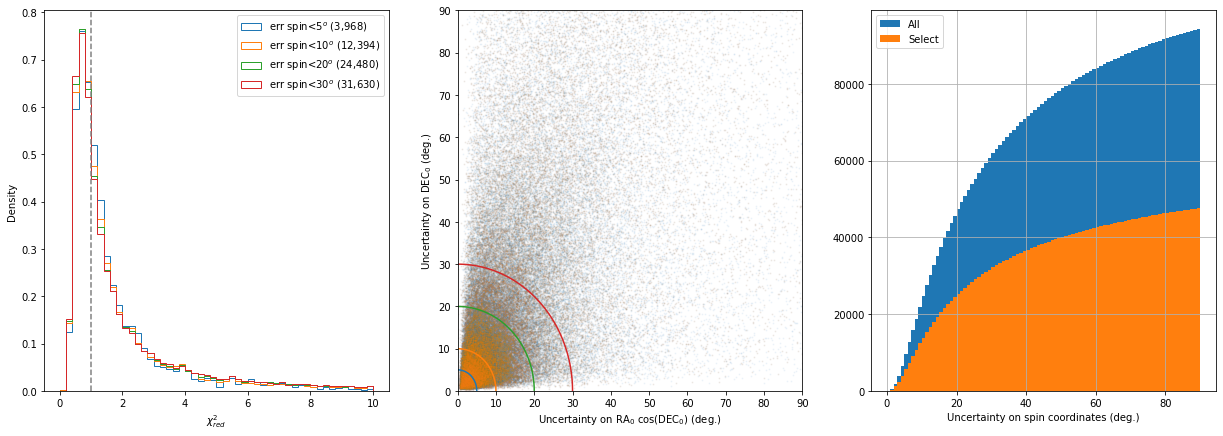

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))


# Histogram of chi2
for err in [5, 10, 20, 30]:
    cond = maskFINK
    cond = cond * (data.SHG1G2_dSpin <= err)
    ax[0].hist(
        data.loc[cond, "SHG1G2_chi2red"],
        bins=50,
        histtype="step",
        density=True,
        range=[0, 10],
        label=f"err spin<{err:d}$^o$ ({len(data[cond]):,d})",
    )

    theta = np.linspace(0, np.pi / 2, num=90)
    ax[1].plot(err * np.cos(theta), err * np.sin(theta))

ax[0].axvline(1, ls="--", color="grey")
ax[0].set_xlabel(r"$\chi^2_{red}$")
ax[0].set_ylabel("Density")
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter(
    data.SHG1G2_dalpha0 * np.cos(np.radians(data["SHG1G2_delta0"])),
    data.SHG1G2_ddelta0,
    s=1,
    alpha=0.05,
)
ax[1].scatter(
    data.loc[maskFINK, "SHG1G2_dalpha0"]
    * np.cos(np.radians(data.loc[maskFINK, "SHG1G2_delta0"])),
    data.loc[maskFINK, "SHG1G2_ddelta0"],
    s=1,
    alpha=0.05,
)
ax[1].set_xlim(0, 90)
ax[1].set_ylim(0, 90)

ax[1].set_xlabel("Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)")
ax[1].set_ylabel("Uncertainty on DEC$_0$ (deg.)")

# Cumulative dSpin
r = [0, 90]
b = 90
ax[2].hist(
    data.SHG1G2_dSpin, cumulative=True, density=False, range=r, bins=b, label="All"
)
ax[2].hist(
    data.loc[maskFINK, "SHG1G2_dSpin"],
    cumulative=True,
    density=False,
    range=r,
    bins=b,
    label="Select",
)

ax[2].grid()
ax[2].set_xlabel("Uncertainty on spin coordinates (deg.)")
ax[2].legend(loc="upper left")

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)

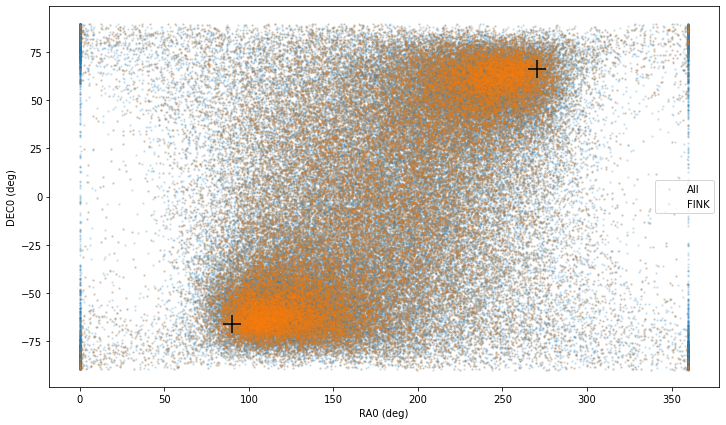

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# All
cond = data.ssnamenr == data.ssnamenr
ax.scatter(data.loc[cond, xax], data.loc[cond, yax], s=2, alpha=0.15, label="All")

# FINK sample
cond = maskFINK
ax.scatter(data.loc[cond, xax], data.loc[cond, yax], s=2, alpha=0.15, label="FINK")


# Ecliptic poles
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)

coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=-89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)


ax.set_xlabel("RA0 (deg)")
ax.set_ylabel("DEC0 (deg)")
ax.legend()

fig.savefig(os.path.join(data_fink, "gfx", "models", "sky_bulk.png"), facecolor="white")

- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

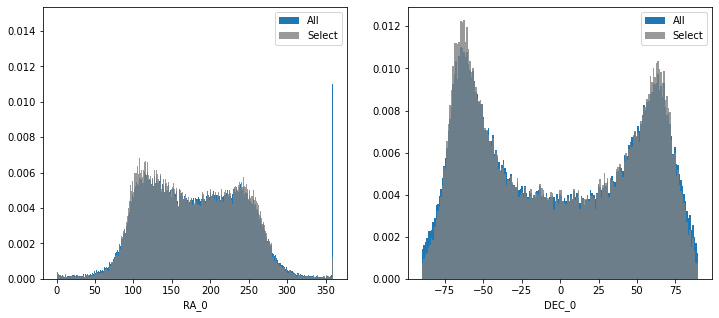

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(data.SHG1G2_alpha0, range=[0, 360], bins=361, density=True, label="All")
ax[0].hist(
    data.loc[maskFINK, "SHG1G2_alpha0"],
    range=[0, 360],
    bins=361,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[0].legend()
ax[0].set_xlabel("RA_0")

ax[1].hist(data.SHG1G2_delta0, range=[-90, 90], bins=181, density=True, label="All")
ax[1].hist(
    data.loc[maskFINK, "SHG1G2_delta0"],
    range=[-90, 90],
    bins=181,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[1].legend()
ax[1].set_xlabel("DEC_0")

In [16]:
# Flip half of the solution
cond = data.index % 2 == 0
xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

data.loc[cond, xax] = (data.loc[cond, xax] + 180) % 360
data.loc[cond, yax] = -data.loc[cond, yax]

# Convert to EC
coords = SkyCoord(
    ra=data.loc[cond, xax].values * u.deg,
    dec=data.loc[cond, yax].values * u.deg,
    distance=200 * u.parsec,
    frame="hcrs",
)
data.loc[cond, "lon"] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond, "lat"] = coords.heliocentricmeanecliptic.lat.value

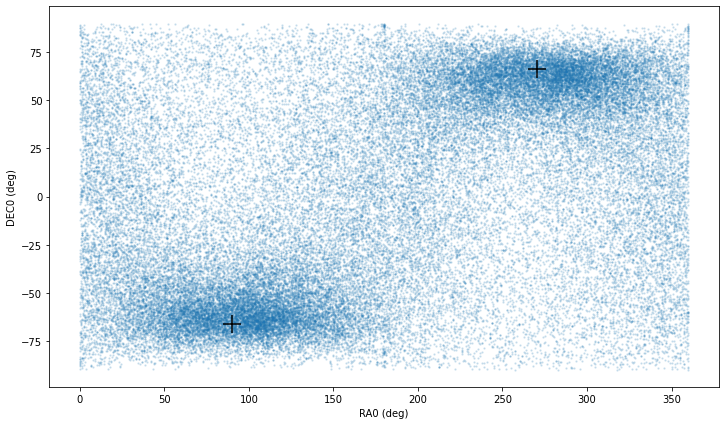

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# Sample FINK
ax.scatter(data.loc[maskFINK, xax], data.loc[maskFINK, yax], s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=-89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)


ax.set_xlabel("RA0 (deg)")
ax.set_ylabel("DEC0 (deg)")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_selected.png"), facecolor="white"
)

# Compare with literature

In [18]:
data["spins.1.technique"].value_counts()

spins.1.technique
LC        15853
LCI        9912
LC+TPM      570
TE           50
ADAM         45
LC-TPM       40
Radar        18
LC+Occ       18
SPACE         6
A-M           5
SAGE          4
LC+IM         4
TE-Occ        1
Bin-IM        1
Name: count, dtype: int64

In [20]:
# Compute angular distances
spin_version = np.array(["A", "B"])

for ks in ["1", "2", "3", "4"]:
    data[f"spins.{ks}.distance"] = np.nan
    cond = ~data[f"spins.{ks}.RA0.value"].isna()

    # ------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond, f"spins.{ks}.distance.A"] = data.loc[
        cond,
        [
            f"spins.{ks}.RA0.value",
            f"spins.{ks}.DEC0.value",
            "SHG1G2_alpha0",
            "SHG1G2_delta0",
        ],
    ].apply(
        lambda x: np.degrees(
            angular_separation(
                np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
            )
        ),
        axis=1,
    )
    data.loc[cond, f"spins.{ks}.delta_RA.A"] = (
        data.loc[cond, f"spins.{ks}.RA0.value"] - data.loc[cond, "SHG1G2_alpha0"]
    ) * np.cos(np.radians(data.loc[cond, f"spins.{ks}.DEC0.value"]))
    data.loc[cond, f"spins.{ks}.delta_DEC.A"] = (
        data.loc[cond, f"spins.{ks}.DEC0.value"] - data.loc[cond, "SHG1G2_delta0"]
    )
    data.loc[cond, f"spins.{ks}.RA.A"] = data.loc[cond, f"spins.{ks}.RA0.value"]
    data.loc[cond, f"spins.{ks}.DEC.A"] = data.loc[cond, f"spins.{ks}.DEC0.value"]

    # ------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond, f"spins.{ks}.distance.B"] = data.loc[
        cond,
        [
            f"spins.{ks}.RA0.value",
            f"spins.{ks}.DEC0.value",
            "SHG1G2_alpha0",
            "SHG1G2_delta0",
        ],
    ].apply(
        lambda x: np.degrees(
            angular_separation(
                np.radians((x[0] + 180) % 360),
                np.radians(-x[1]),
                np.radians(x[2]),
                np.radians(x[3]),
            )
        ),
        axis=1,
    )
    data.loc[cond, f"spins.{ks}.delta_RA.B"] = (
        ((data.loc[cond, f"spins.{ks}.RA0.value"] + 180.0) % 360)
        - data.loc[cond, "SHG1G2_alpha0"]
    ) * np.cos(np.radians(-data.loc[cond, f"spins.{ks}.DEC0.value"]))
    data.loc[cond, f"spins.{ks}.delta_DEC.B"] = (
        -data.loc[cond, f"spins.{ks}.DEC0.value"] - data.loc[cond, "SHG1G2_delta0"]
    )
    data.loc[cond, f"spins.{ks}.RA.B"] = (
        data.loc[cond, f"spins.{ks}.RA0.value"] + 180.0
    ) % 360
    data.loc[cond, f"spins.{ks}.DEC.B"] = -data.loc[cond, f"spins.{ks}.DEC0.value"]

    # ------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond, f"spins.{ks}.closest"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: int(np.argmin(x)), axis=1)
    data = data.astype({f"spins.{ks}.closest": "Int64"})

    data.loc[cond, f"spins.{ks}.distance"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: np.min(x), axis=1)
    data.loc[cond, f"spins.{ks}.version"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: spin_version[np.argmin(x)], axis=1)

    # ------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond, f"spins.{ks}.delta_RA"] = data.loc[
        cond,
        [f"spins.{ks}.delta_RA.A", f"spins.{ks}.delta_RA.B", f"spins.{ks}.closest"],
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.delta_DEC"] = data.loc[
        cond,
        [f"spins.{ks}.delta_DEC.A", f"spins.{ks}.delta_DEC.B", f"spins.{ks}.closest"],
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.RA"] = data.loc[
        cond, [f"spins.{ks}.RA.A", f"spins.{ks}.RA.B", f"spins.{ks}.closest"]
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.DEC"] = data.loc[
        cond, [f"spins.{ks}.RA.A", f"spins.{ks}.RA.B", f"spins.{ks}.closest"]
    ].apply(lambda x: x[int(x[2])], axis=1)


# Select the closest angularly
cond = ~data[f"spins.1.distance"].isna()
data.loc[cond, "spins.closest"] = data.loc[
    cond,
    ["spins.1.distance", "spins.2.distance", "spins.3.distance", "spins.4.distance"],
].apply(lambda x: int(np.argmin(x)), axis=1)
data = data.astype({"spins.closest": "Int64"})

data.loc[cond, "spins.distance"] = data.loc[
    cond,
    ["spins.1.distance", "spins.2.distance", "spins.3.distance", "spins.4.distance"],
].apply(lambda x: np.min(x), axis=1)
data.loc[cond, "spins.delta_RA"] = data.loc[
    cond,
    [
        f"spins.1.delta_RA",
        f"spins.2.delta_RA",
        f"spins.3.delta_RA",
        f"spins.4.delta_RA",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.delta_DEC"] = data.loc[
    cond,
    [
        f"spins.1.delta_DEC",
        f"spins.2.delta_DEC",
        f"spins.3.delta_DEC",
        f"spins.4.delta_DEC",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)

data.loc[cond, "spins.err_RA"] = data.loc[
    cond,
    [
        f"spins.1.RA0.error.max",
        f"spins.2.RA0.error.max",
        f"spins.3.RA0.error.max",
        f"spins.4.RA0.error.max",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.err_DEC"] = data.loc[
    cond,
    [
        f"spins.1.DEC0.error.max",
        f"spins.2.DEC0.error.max",
        f"spins.3.DEC0.error.max",
        f"spins.4.DEC0.error.max",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)

data.loc[cond, "spins.RA"] = data.loc[
    cond, [f"spins.1.RA", f"spins.2.RA", f"spins.3.RA", f"spins.4.RA", f"spins.closest"]
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.DEC"] = data.loc[
    cond,
    [f"spins.1.DEC", f"spins.2.DEC", f"spins.3.DEC", f"spins.4.DEC", f"spins.closest"],
].apply(lambda x: x[int(x[4])], axis=1)

In [21]:
for c in ["spins.RA", "spins.DEC", "spins.err_RA", "spins.err_DEC"]:
    missing = data[c].isna()
    data.loc[missing, c] = 15.0

In [22]:
for c in ["spins.RA", "spins.DEC", "spins.err_RA", "spins.err_DEC"]:
    missing = data[c].isna()
    print(c, len(data[missing]))
    data[c] = data[c].astype(float)
len(data)

spins.RA 0
spins.DEC 0
spins.err_RA 0
spins.err_DEC 0


122606

In [23]:
data.loc[cond, "spins.dSpin"] = np.sqrt(
    (data.loc[cond, "spins.err_RA"] * np.cos(np.radians(data.loc[cond, "spins.DEC"])))
    ** 2
    + data.loc[cond, "spins.err_DEC"] ** 2
)

/tmp/ipykernel_1109049/1164014787.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[cond,'spins.dSpin'] = np.sqrt( (data.loc[cond,'spins.err_RA']*np.cos(np.radians(data.loc[cond,'spins.DEC'])))**2 + data.loc[cond,'spins.err_DEC']**2 )


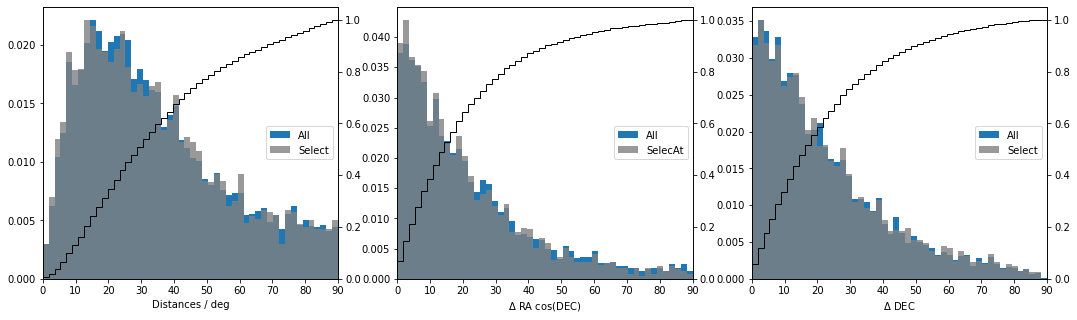

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

cond = data.ssnamenr == data.ssnamenr

r = [0, 90]
b = 50
ax[0].hist(data.loc[cond, "spins.distance"], range=r, bins=b, density=True, label="All")
ax[0].hist(
    data.loc[maskFINK, "spins.distance"],
    range=r,
    bins=b,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[0].legend(loc="center right")
ax[0].set_xlabel("Distances / deg")
ax0 = ax[0].twinx()
ax0.hist(
    data.loc[maskFINK, "spins.distance"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[0].set_xlim(r)

ax[1].hist(data.loc[cond, "spins.delta_RA"], range=r, bins=b, density=True, label="All")
ax[1].hist(
    data.loc[maskFINK, "spins.delta_RA"],
    range=r,
    bins=b,
    density=True,
    label="SelecAt",
    color="grey",
    alpha=0.8,
)
ax[1].legend(loc="center right")
ax[1].set_xlabel("$\Delta$ RA cos(DEC)")
ax1 = ax[1].twinx()
ax1.hist(
    data.loc[maskFINK, "spins.delta_RA"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[1].set_xlim(r)

ax[2].hist(
    data.loc[cond, "spins.delta_DEC"], range=r, bins=b, density=True, label="All"
)
ax[2].hist(
    data.loc[maskFINK, "spins.delta_DEC"],
    range=r,
    bins=b,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[2].legend(loc="center right")
ax[2].set_xlabel("$\Delta$ DEC")
ax2 = ax[2].twinx()
ax2.hist(
    data.loc[maskFINK, "spins.delta_DEC"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[2].set_xlim(r)

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances.png"), facecolor="white"
)

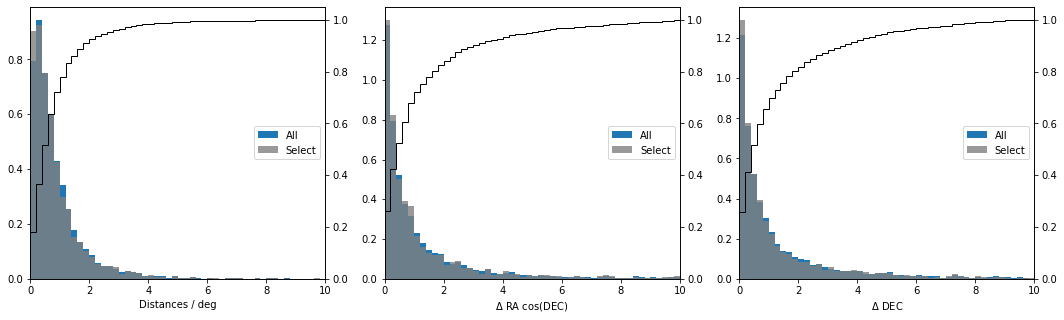

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))


r = [0, 10]
b = 50

x = data["spins.distance"] / np.sqrt(
    data["SHG1G2_dSpin"] ** 2 + data["spins.dSpin"] ** 2
)
ax[0].hist(x, range=r, bins=b, density=True, label="All")
ax[0].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[0].legend(loc="center right")
ax[0].set_xlabel("Distances / deg")
ax0 = ax[0].twinx()
ax0.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[0].set_xlim(r)

x = data["spins.delta_RA"] / data["SHG1G2_dalpha0"]
ax[1].hist(x, range=r, bins=b, density=True, label="All")
ax[1].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[1].legend(loc="center right")
ax[1].set_xlabel("$\Delta$ RA cos(DEC)")
ax1 = ax[1].twinx()
ax1.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[1].set_xlim(r)

x = data["spins.delta_DEC"] / data["SHG1G2_ddelta0"]
ax[2].hist(x, range=r, bins=b, density=True, label="All")
ax[2].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[2].legend(loc="center right")
ax[2].set_xlabel("$\Delta$ DEC")
ax2 = ax[2].twinx()
ax2.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[2].set_xlim(r)

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_normed.png"),
    facecolor="white",
)

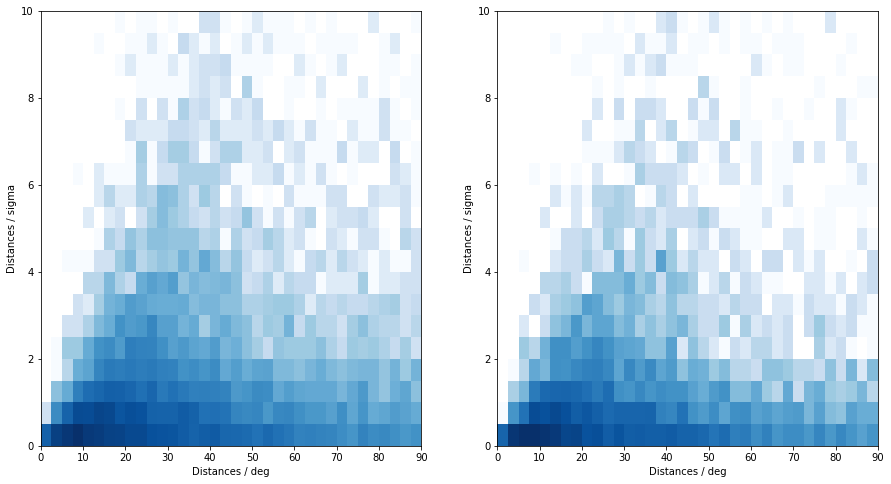

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

r = [[0, 90], [0, 10]]
b = [36, 20]

x = data["spins.distance"]
y = data["spins.distance"] / data["SHG1G2_dSpin"]
ax[0].hist2d(x, y, label="All", range=r, bins=b, cmap="Blues", norm="log", density=True)
ax[1].hist2d(
    x[maskFINK],
    y[maskFINK],
    label="Select",
    range=r,
    bins=b,
    cmap="Blues",
    norm="log",
    density=True,
)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel("Distances / deg")
    a.set_ylabel("Distances / sigma")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_vs_sigma.png"),
    facecolor="white",
)

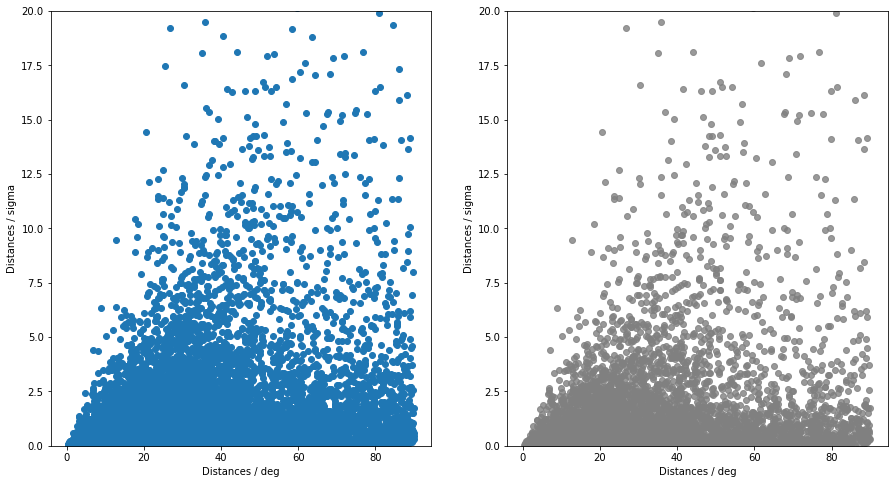

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

r = [[0, 90], [0, 20]]
# b = [90,50]

x = data["spins.distance"]  # / data['SHG1G2_dSpin']
y = data["spins.distance"] / data["SHG1G2_dSpin"]
ax[0].scatter(x, y, label="All")
ax[1].scatter(x[maskFINK], y[maskFINK], label="Select", color="grey", alpha=0.8)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel("Distances / deg")
    a.set_ylabel("Distances / sigma")
    a.set_ylim(r[1])

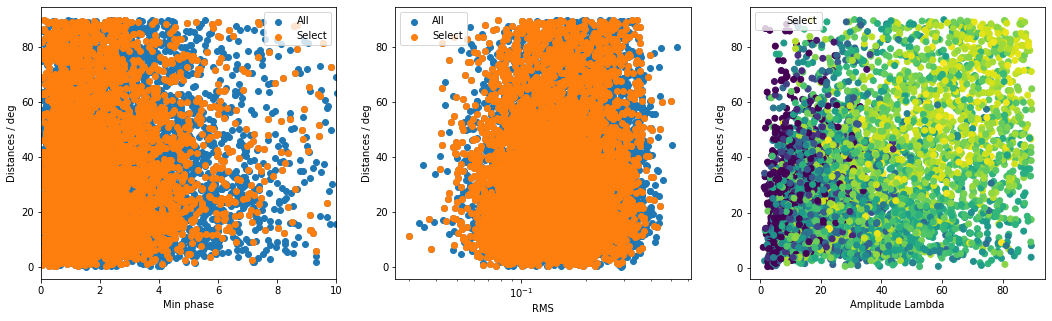

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

x = data["min_phase"]
y = data["spins.distance"]
ax[0].scatter(x, y, label="All")
ax[0].scatter(x[maskFINK], y[maskFINK], label="Select")
ax[0].legend()
ax[0].set_xlabel("Min phase")
ax[0].set_ylabel("Distances / deg")
ax[0].set_xlim(0, 10)

x = data["SHG1G2_rms"]
y = data["spins.distance"]
ax[1].scatter(x, y, label="All")
ax[1].scatter(x[maskFINK], y[maskFINK], label="Select")
ax[1].legend()
ax[1].set_xlabel("RMS")
ax[1].set_xscale("log")
ax[1].set_ylabel("Distances / deg")

# x = np.degrees(np.arccos(data['SHG1G2_maxCosLambda'] - data['SHG1G2_minCosLambda']))
x = np.degrees(
    np.arccos(data["SHG1G2_min_cos_lambda"]) - np.arccos(data["SHG1G2_max_cos_lambda"])
)
y = data["spins.distance"]
# ax[2].scatter( x, y, label='All' )
ax[2].scatter(
    x[maskFINK], y[maskFINK], c=data.loc[maskFINK, "SHG1G2_R"], label="Select"
)
ax[2].legend()
ax[2].set_xlabel("Amplitude Lambda")
# ax[2].set_yscale('log')
ax[2].set_ylabel("Distances / deg")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_vs_obs.png"),
    facecolor="white",
)

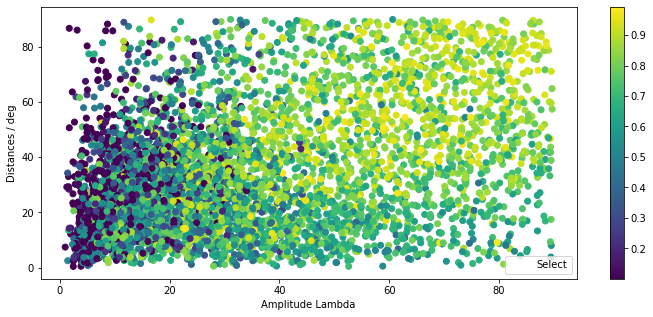

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))

x = np.degrees(
    np.arccos(data["SHG1G2_min_cos_lambda"]) - np.arccos(data["SHG1G2_max_cos_lambda"])
)
y = data["spins.distance"]
im = ax.scatter(
    x[maskFINK], y[maskFINK], c=data.loc[maskFINK, "SHG1G2_R"], label="Select"
)
ax.legend()
ax.set_xlabel("Amplitude Lambda")
ax.set_ylabel("Distances / deg")

fig.colorbar(im)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

Text(0, 0.5, 'Distances / deg')

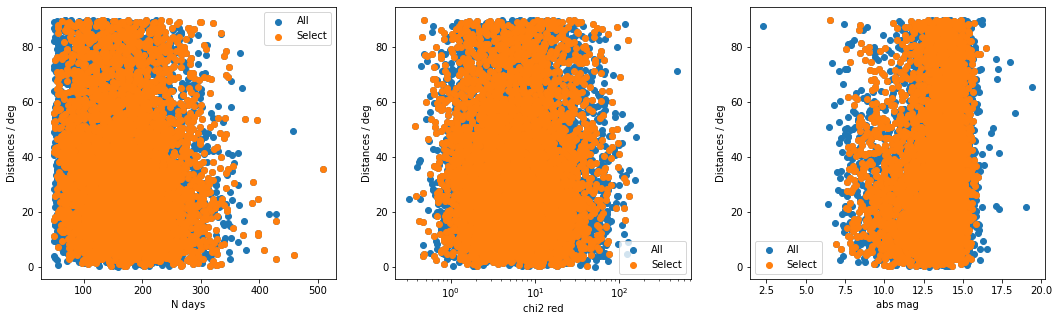

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

cond = data.ssnamenr == data.ssnamenr

ax[0].scatter(data.loc[cond, "n_days"], data.loc[cond, "spins.distance"], label="All")
ax[0].scatter(
    data.loc[maskFINK, "n_days"], data.loc[maskFINK, "spins.distance"], label="Select"
)
ax[0].legend()
ax[0].set_xlabel("N days")
ax[0].set_ylabel("Distances / deg")

ax[1].scatter(
    data.loc[cond, "SHG1G2_chi2red"], data.loc[cond, "spins.distance"], label="All"
)
ax[1].scatter(
    data.loc[maskFINK, "SHG1G2_chi2red"],
    data.loc[maskFINK, "spins.distance"],
    label="Select",
)
ax[1].legend()
ax[1].set_xlabel("chi2 red")
ax[1].set_xscale("log")
ax[1].set_ylabel("Distances / deg")

ax[2].scatter(
    data.loc[cond, "absolute_magnitude.value"],
    data.loc[cond, "spins.distance"],
    label="All",
)
ax[2].scatter(
    data.loc[maskFINK, "absolute_magnitude.value"],
    data.loc[maskFINK, "spins.distance"],
    label="Select",
)
ax[2].legend()
ax[2].set_xlabel("abs mag")
# ax[2].set_xscale('log')
ax[2].set_ylabel("Distances / deg")

(62867, 10260)

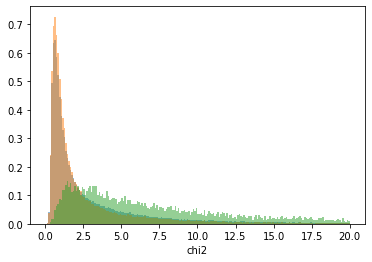

In [31]:
r = [0, 20]
b = 200
plt.hist(data["SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)
plt.hist(data.loc[maskFINK, "SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)

cond = data["spins.1.RA0.value"].notna()
plt.hist(data.loc[cond, "SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)
# plt.xlim(0,10)
plt.xlabel("chi2")

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(62867, 10260)

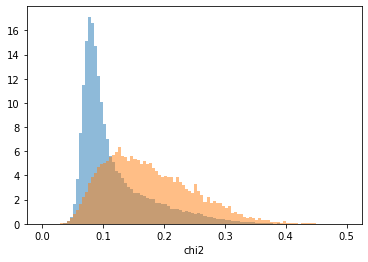

In [32]:
r = [0, 0.5]
b = 100
# plt.hist(data['SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK, "SHG1G2_rms"], range=r, bins=b, alpha=0.5, density=True)

cond = data["spins.1.RA0.value"].notna()
plt.hist(data.loc[cond, "SHG1G2_rms"], range=r, bins=b, alpha=0.5, density=True)
# plt.xlim(0,10)
plt.xlabel("chi2")

len(data[maskFINK]), len(data[cond])

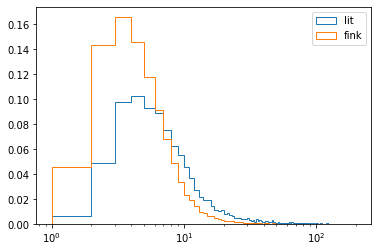

In [33]:
fig, ax = plt.subplots()

ax.hist(
    data.loc[cond, "diameter.value"],
    histtype="step",
    bins=np.linspace(1, 200, num=200),
    density=True,
    label="lit",
)
ax.hist(
    data.loc[maskFINK, "diameter.value"],
    histtype="step",
    bins=np.linspace(1, 200, num=200),
    density=True,
    label="fink",
)

ax.set_xscale("log")
ax.legend()

In [34]:
cond = maskFINK
lim_spin = 30
spin_v = "1"
cond = cond * (data[f"spins.{spin_v}.distance"] < lim_spin)
data.loc[cond, f"spins.{spin_v}.technique"].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

spins.1.technique
LCI       1839
LC+TPM      90
LC          15
LC-TPM       7
ADAM         6
LC+Occ       3
TE           2
Radar        2
LC+IM        1
Name: count, dtype: int64

In [35]:
cond = maskFINK
data[cond].sort_values(by="sso_number").head(20)

,ssnamenr,HG_chi2red,HG_status,HG_fit,HG_rms,HG_rms_g,HG_rms_r,HG_median_error_phot,HG_median_error_phot_1,HG_median_error_phot_2,...,spins.4.DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin
1202,24,4.138918,2.0,0.0,0.043204,0.039938,0.048306,0.022072,0.022072,0.021773,...,NaN,0,6.717321,-6.755713,1.478554,3.667,2.576,66.135000,66.135000,2.972686
70280,33,5.222711,2.0,0.0,0.055226,0.057039,0.053935,0.024150,0.023779,0.024330,...,NaN,0,45.480632,216.367296,36.013224,2.124,3.267,339.160000,339.160000,3.822785
122187,35,61.065464,2.0,0.0,0.166387,0.161409,0.171861,0.023051,0.023140,0.022921,...,NaN,0,51.996656,44.510208,36.437939,30.000,30.000,191.581000,191.581000,41.996766
81331,38,18.934998,2.0,0.0,0.092678,0.091143,0.094324,0.022102,0.021948,0.023030,...,NaN,1,11.371542,2.327935,11.123543,5.000,5.000,166.679000,166.679000,6.976591
96524,45,157.805786,2.0,0.0,0.259549,0.250678,0.267388,0.022634,0.022116,0.023200,...,NaN,0,27.848457,-7.947385,-26.937805,2.000,2.000,301.039000,301.039000,2.250214
37466,46,13.874402,2.0,0.0,0.074198,0.074805,0.073862,0.022142,0.022198,0.022086,...,NaN,0,21.653922,-12.877696,18.396556,5.000,5.000,292.808000,292.808000,5.362528
81748,47,29.592281,2.0,0.0,0.109501,0.113866,0.103394,0.021921,0.021685,0.022142,...,NaN,0,29.760466,219.627282,16.293851,5.000,5.000,335.521000,335.521000,6.760743
38786,49,6.231858,2.0,0.0,0.055910,0.051891,0.057959,0.024265,0.022289,0.024753,...,NaN,<NA>,NaN,NaN,NaN,15.000,15.000,15.000000,15.000000,NaN
86557,50,7.390789,2.0,0.0,0.071863,0.059731,0.079941,0.026356,0.024323,0.027190,...,NaN,1,55.039101,-1.249371,55.030273,30.000,30.000,99.888000,99.888000,30.439117
101044,54,10.259078,2.0,0.0,0.061132,0.054861,0.066899,0.021778,0.022387,0.021012,...,NaN,0,8.832891,4.199051,7.851634,4.000,3.000,343.635426,343.635426,4.871333


In [36]:
cond = maskFINK
showcols = [
    "number",
    "name",  #'minphase','maxphase','n_days',
    "SHG1G2_alpha0",
    "SHG1G2_delta0",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.version",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.version",
    "spins.1.distance",
    "spins.2.distance",
]
data.loc[cond, showcols].sort_values(by="number").head(20)

,number,name,SHG1G2_alpha0,SHG1G2_delta0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
1202,24,Themis,81.834778,-65.991554,246.135000,64.513000,B,NaN,NaN,NaN,6.717321,NaN
70280,33,Polyhymnia,12.697861,12.475776,159.160000,-48.489000,B,33.170,-41.402,A,45.480632,57.094533
122187,35,Leukothea,145.773972,-50.103939,11.581000,13.666000,B,195.126,-5.372,A,51.996656,60.803617
81331,38,Leda,164.297150,1.090457,155.139000,-7.940000,A,346.679,-12.214,B,12.843127,11.371542
96524,45,Eugenia,309.307281,42.952805,121.039000,-16.015000,B,NaN,NaN,NaN,27.848457,NaN
37466,46,Hestia,307.513168,-47.265556,112.808000,28.869000,B,290.700,-8.943,A,21.653922,40.897957
81748,47,Aglaja,19.720200,-62.229851,155.521000,45.936000,B,317.916,-3.910,A,29.760466,73.741784
38786,49,Pales,264.231384,66.141663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86557,50,Virginia,101.139015,-57.968273,105.532000,34.741000,B,279.888,2.938,B,87.217279,55.039101
101044,54,Alexandra,338.986862,-33.256264,163.635426,25.404629,B,NaN,NaN,NaN,8.832891,NaN


In [37]:
data.columns[:80]

Index(['ssnamenr', 'HG_chi2red', 'HG_status', 'HG_fit', 'HG_rms', 'HG_rms_g',
       'HG_rms_r', 'HG_median_error_phot', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       'HG_H_r', 'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_flag', 'HG1G2_chi2red',
       'HG1G2_status', 'HG1G2_fit', 'HG1G2_rms', 'HG1G2_rms_g', 'HG1G2_rms_r',
       'HG1G2_median_error_phot', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g',
       'HG1G2_dG1_g', 'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_H_r', 'HG1G2_dH_r',
       'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_flag',
       'SHG1G2_chi2red', 'SHG1G2_min_cos_lambda', 'SHG1G2_mean_cos_lambda',
       'SHG1G2_max_cos_lambda', 'SHG1G2_status', 'SHG1G2_fit', 'SHG1G2_rms',
       'SHG1G2_rms_g', 'SHG1G2_rms_r', 'SHG1G2_median_error_phot',
       'SHG1G2_median_error_phot_1', 'SHG1G2_median_error_phot_2', 'n_obs',
       'n_obs_g', 'n_obs_r', 

# Obliquity

In [38]:
# Obliquity of the spin
data["lon_orbit"] = data["orbital_elements.node_longitude.value"] - 90
data["lat_orbit"] = 90.0 - data["orbital_elements.inclination.value"]
data["obliquity"] = data[["lon", "lat", "lon_orbit", "lat_orbit"]].apply(
    lambda x: np.degrees(
        angular_separation(
            np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
        )
    ),
    axis=1,
)

/tmp/ipykernel_1109049/2383006645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
/tmp/ipykernel_1109049/2383006645.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
/tmp/ipykernel_1109049/2383006645.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

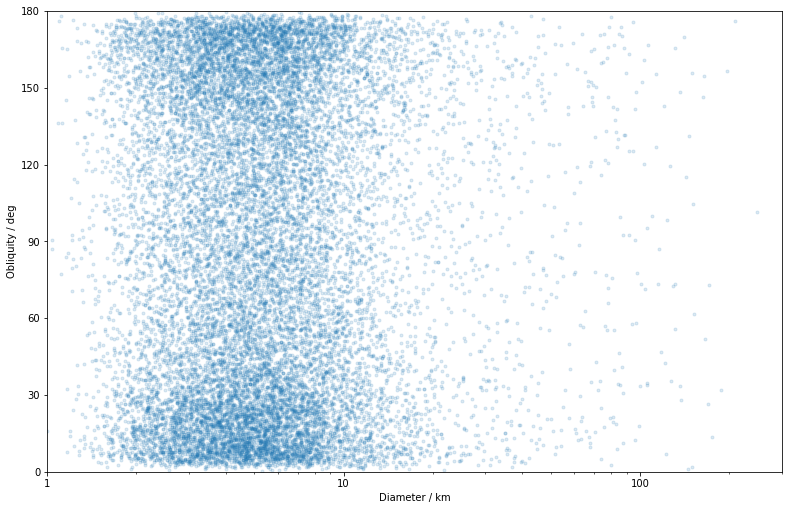

In [39]:
fig, ax = plt.subplots(
    figsize=(12, 8), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

cond = data.ssnamenr == data.ssnamenr
cond = maskFINK
ax.scatter(
    data.loc[cond, "diameter.value"],
    data.loc[cond, "obliquity"],
    marker=".",
    # color=colors[0],
    # s=2,
    alpha=0.15,
)

ax.set_xscale("log")
ax.set_xlim(1, 300)
ax.set_ylim(0, 180)
ax.set_xlabel("Diameter / km")
ax.set_ylabel("Obliquity / deg")


ax.set_xticks([1, 10, 100])
ax.set_xticklabels(["1", "10", "100"])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "obliquity_vs_diameter.png"),
    facecolor="white",
)

(array([326., 921., 795., 734., 686., 612., 503., 424., 379., 352., 308.,
        347., 281., 300., 281., 264., 273., 311., 275., 262., 273., 265.,
        277., 296., 278., 286., 329., 309., 350., 404., 438., 494., 555.,
        603., 708., 749., 307.]),
 array([  0.        ,   4.86486486,   9.72972973,  14.59459459,
         19.45945946,  24.32432432,  29.18918919,  34.05405405,
         38.91891892,  43.78378378,  48.64864865,  53.51351351,
         58.37837838,  63.24324324,  68.10810811,  72.97297297,
         77.83783784,  82.7027027 ,  87.56756757,  92.43243243,
         97.2972973 , 102.16216216, 107.02702703, 111.89189189,
        116.75675676, 121.62162162, 126.48648649, 131.35135135,
        136.21621622, 141.08108108, 145.94594595, 150.81081081,
        155.67567568, 160.54054054, 165.40540541, 170.27027027,
        175.13513514, 180.        ]),
 <BarContainer object of 37 artists>)

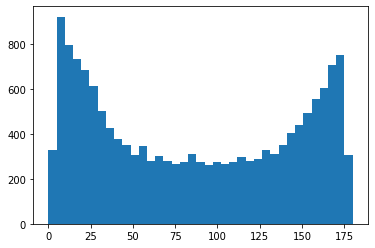

In [40]:
cond = maskFINK & (data["diameter.value"] < 10)
fig, ax = plt.subplots()

r = [0, 180]
b = 37
ax.hist(data.loc[cond, "obliquity"], bins=b, range=r)

In [41]:
np.sqrt(2 * np.pi / (5 * 3600)), np.sqrt(2 * np.pi / (5 * 365.24 * 86400))

(0.01868330405465976, 0.00019955329064394955)

In [42]:
nu = [1e-8, 1e-4]

ti = 200
emissivity = 0.9
sigma_b = 5.670374419e-8
S_sun = 1360
beaming = 0.9
delta = 3.0
pV = 0.15
A = (0.29 + 0.684 * 0.15) * pV

theta = (
    ti
    * np.sqrt(nu)
    * ((beaming * delta**2) ** (3 / 4))
    * ((sigma_b * emissivity) ** (-1 / 4))
    * (((1 - A) * S_sun) ** (-3 / 4))
)

W = -0.5 * theta / (1 + theta + 0.5 * theta**2)

Wn = W[0]
Ww = W[1]

print(W)

[-0.01448942 -0.17681723]


In [43]:
data.loc[maskFINK, "family.family_name"].value_counts().head(30)

family.family_name
Vesta         2608
Eos           2081
Hertha        1694
Koronis       1539
Themis         948
Maria          768
Astraea        711
Eulalia        666
Eunomia        603
Hygiea         594
Phocaea        594
Baptistina     522
Minerva        497
Iduna          472
Hungaria       395
Adeona         321
Flora          320
Mnemosyne      306
Massalia       303
Levin          252
Euphrosyne     219
Dora           213
Veritas        182
Tirela         173
Eurynome       164
Hansa          162
Agnia          157
Erigone        146
Rafita         143
Taiyuan        127
Name: count, dtype: int64

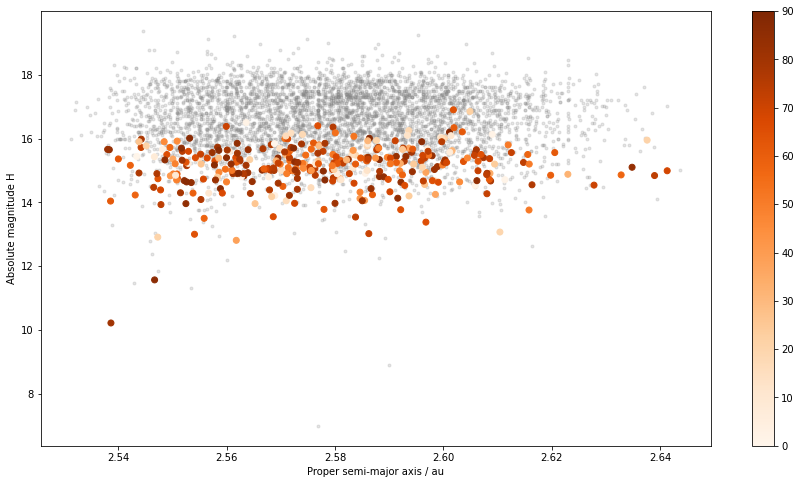

In [44]:
fig, ax = plt.subplots(figsize=(15, 8))

f = "Astraea"

cond = bft["family.family_name"] == f
ax.scatter(
    bft.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    bft.loc[cond, "absolute_magnitude.value"],
    color="grey",
    alpha=0.2,
    marker=".",
)


cond = maskFINK & (data["family.family_name"] == f)
im = ax.scatter(
    data.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    data.loc[cond, "absolute_magnitude.value"],
    c=np.abs(data.loc[cond, "obliquity"] - 90),
    vmin=0,
    vmax=90,
    alpha=1.0,
    marker="o",
    cmap="Oranges",
)

ax.set_xlabel("Proper semi-major axis / au")
ax.set_ylabel("Absolute magnitude H")
fig.colorbar(im)

# Oblateness

In [45]:
damit = pd.read_csv(os.path.join(data_fink, "data", "damit.csv"))

In [46]:
np.mean(damit.R), np.mean(damit.R2)

(0.6131972585404972, 0.7431183878107458)

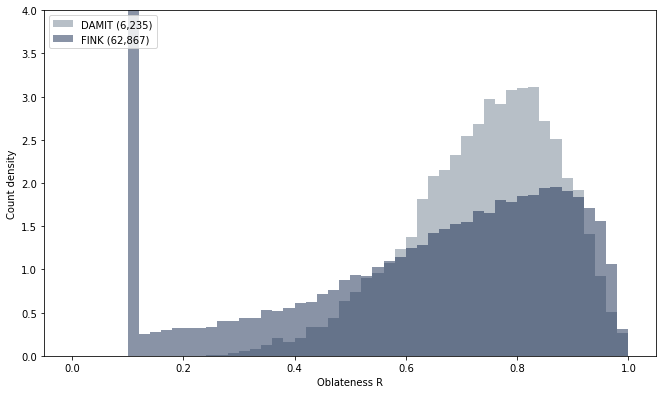

In [47]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5),
fig, ax = plt.subplots(
    figsize=(10, 6), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

r = [0, 1]
b = 50

colors = ["#15284F", "#F5622E"]


# ax.hist( damit.R, range=r, bins=b,
#         color='lightgray',
#         density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist(
    damit.R2,
    range=r,
    bins=b,
    color="slategray",
    density=True,
    alpha=0.5,
    label=f"DAMIT ({len(damit):,d})",
)
# ax.hist( data.loc[maskFINK,'SHG1G2_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.SHG1G2_dR < 0.9) & maskFINK
ax.hist(
    data.loc[cond, "SHG1G2_R"],
    range=r,
    bins=b,
    color=colors[0],
    density=True,
    alpha=0.5,
    label=f"FINK ({len(data[maskFINK]):,d})",
)

ax.set_ylim(0, 4)
ax.set_xlabel("Oblateness R")
ax.set_ylabel("Count density")
ax.legend(loc="upper left")

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)

Text(0.5, 0, '(FINK R - DAMIT R) / dR')

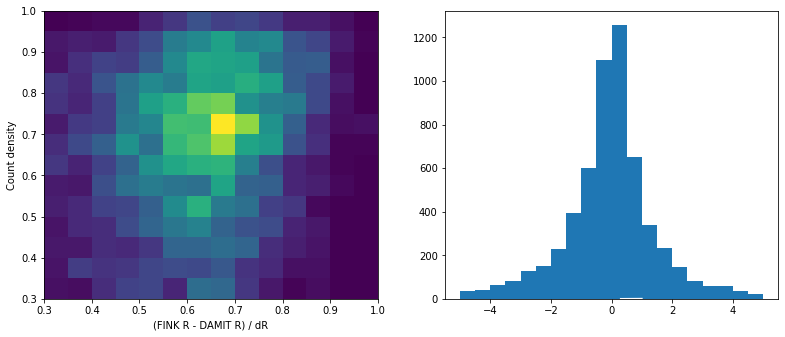

In [48]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5),
fig, ax = plt.subplots(
    1, 2, figsize=(12, 5), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

r = [0, 1]
b = 50

colors = ["#15284F", "#F5622E"]

x = damit.merge(data, left_on="number", right_on="sso_number")

# ax.scatter( x.R, x.SHG1G2_R )
ax[0].hist2d(x.R, x.SHG1G2_R, range=[[0.3, 1], [0.3, 1]], bins=14)
xx = np.linspace(0.3, 1, num=10)
ax[1].plot(xx, xx, color="white")

ax[1].hist((x.R - x.SHG1G2_R) / x.SHG1G2_dR, range=[-5, 5], bins=20)


# ax.set_ylim(0,4)
ax[0].set_xlabel("FINK R")
ax[0].set_ylabel("Count density")

ax[0].set_xlabel("(FINK R - DAMIT R) / dR")

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)

In [49]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.SHG1G2_R > 0.18)
data[cond].sort_values(by="SHG1G2_R").head(40)

,ssnamenr,HG_chi2red,HG_status,HG_fit,HG_rms,HG_rms_g,HG_rms_r,HG_median_error_phot,HG_median_error_phot_1,HG_median_error_phot_2,...,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin,lon_orbit,lat_orbit,obliquity
80318,73304,0.547951,2.0,0.0,0.109696,0.064014,0.127239,0.134588,0.141534,0.127604,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,56.778438,82.749432,30.340686
80308,350541,5.380373,1.0,0.0,0.248577,0.187198,0.275267,0.132576,0.155814,0.127847,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,238.365829,72.383075,151.558553
85467,7978,0.669550,2.0,0.0,0.060561,0.050522,0.066009,0.093864,0.116894,0.078313,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,123.757297,88.967402,NaN
53788,18043,0.606771,2.0,0.0,0.080007,0.085943,0.076304,0.118081,0.123776,0.114540,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,26.173630,86.894092,173.266236
107333,6745,4.583260,2.0,0.0,0.177750,0.163238,0.186044,0.095799,0.100688,0.090438,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,37.274395,83.930501,NaN
32731,48340,5.680009,2.0,0.0,0.163338,0.178341,0.151858,0.109786,0.129304,0.094882,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,83.547985,87.510417,NaN
64893,139051,2.222644,2.0,0.0,0.166746,0.164531,0.168224,0.132465,0.143345,0.117153,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,118.480625,84.821519,NaN
20039,153113,0.855912,2.0,0.0,0.090184,0.072420,0.099022,0.129869,0.158341,0.115083,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,90.415805,81.268001,NaN
11912,97564,5.397109,2.0,0.0,0.218165,0.241935,0.198655,0.133645,0.151011,0.122331,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,39.354222,87.097400,5.463833
79299,61617,2.333014,2.0,0.0,0.098554,0.073231,0.113475,0.100147,0.105653,0.096187,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,-64.402028,87.421953,NaN


Text(0, 0.5, 'R')

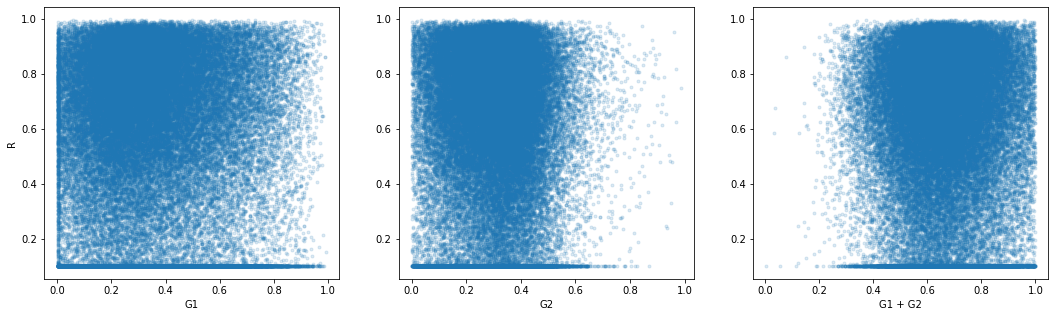

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0, 1]
b = 50


cond = maskFINK

ax[0].scatter(
    data.loc[cond, "SHG1G2_G1_r"], data.loc[cond, "SHG1G2_R"], marker=".", alpha=0.15
)
ax[1].scatter(
    data.loc[cond, "SHG1G2_G2_r"], data.loc[cond, "SHG1G2_R"], marker=".", alpha=0.15
)
ax[2].scatter(
    data.loc[cond, "SHG1G2_G1_r"] + data.loc[cond, "SHG1G2_G2_r"],
    data.loc[cond, "SHG1G2_R"],
    marker=".",
    alpha=0.15,
)

ax[0].set_xlabel("G1")
ax[1].set_xlabel("G2")
ax[2].set_xlabel("G1 + G2")
ax[0].set_ylabel("R")

# ax.legend(loc='upper left')

In [62]:
# fun
data[data["name"].isin(["Benoitcarry", "Julienpeloton"])][
    ["name", "SHG1G2_alpha0", "SHG1G2_delta0", "SHG1G2_R"]
]

,name,SHG1G2_alpha0,SHG1G2_delta0,SHG1G2_R
33753,Benoitcarry,230.939804,-37.992172,0.897608
71303,Julienpeloton,137.001709,-73.602013,0.606224
